In [21]:
%run C:/Users/arpit.goel/Documents/Projects/Kaggle/18_BankConversions/02.Scripts/01.PrepareFeatures.py

C:\Users\arpit.goel\AppData\Local\Continuum2\Anaconda2\lib\site-packages\lightgbm\engine.py:99: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:/Users/arpit.goel/Documents/Projects/Kaggle/18_BankConversions/02.Scripts/01.PrepareFeatures.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  ins['Approved2']=model.predict(ins[idv])
C:/Users/arpit.goel/Documents/Projects/Kaggle/18_BankConversions/02.Scripts/01.PrepareFeatures.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-doc

In [3]:
master_raw=pd.concat([df_train,df_test])
master_raw['table']=np.where(master_raw['Approved'].notnull(),'Train','Test')
master_raw['DOB1']=master_raw['DOB'].map(lambda x: datetime(1900+int(x[6:]),int(x[3:5]),int(x[:2])) if len(str(x))>=8 else datetime(1997,1,1))
master_raw['Lead_Creation_Date1']=master_raw['Lead_Creation_Date'].map(lambda x: datetime(2000+int(x[6:]),int(x[3:5]),int(x[:2])) if len(str(x))>=8 else datetime(1997,1,1))
 

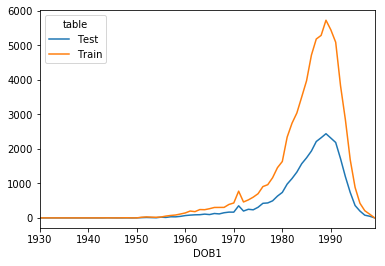

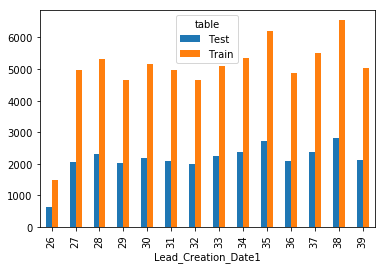

In [6]:
%matplotlib inline
pd.crosstab(master_raw.DOB1.dt.year,master_raw['table']).plot()
pd.crosstab(master_raw.Lead_Creation_Date1.dt.week,master_raw['table']).plot(kind='bar')


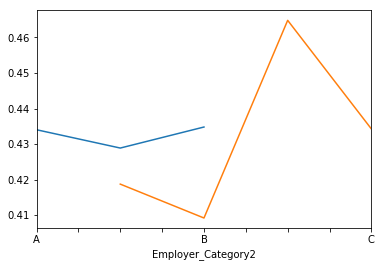

In [14]:
def get_ratio(column):
    a=pd.crosstab(master_raw[column],master_raw['table'])
    a=a['Test']/a['Train']
    a.plot()
    
get_ratio('Employer_Category1')
get_ratio('Employer_Category2')


In [15]:
master_raw.to_csv('03.ParsedData/02.Master.csv')

In [20]:
pd.Series(pd.factorize(master_raw['Employer_Category1'])[0]).value_counts()

 0    47805
 2    25800
 1    20522
-1     5623
dtype: int64

In [ ]:
ins[['Approved1','Approved2','Approved']].mean()

In [ ]:
cat_cols=ins[idv].dtypes
cat_cols.index=range(len(idv))
cat_cols=cat_cols[cat_cols=='category'].index.tolist()

In [ ]:
idv=[x for x in train.columns if x[:4] in ('FEAT','CONT','COUN')]
target='Approved'
msk=np.random.rand(len(train))<0.75
ins=train[msk]
oos=train[~msk]


In [ ]:
ins[idv].mean().sort_values()

In [ ]:
from sklearn import metrics
%matplotlib inline
def get_roc(df,score,target):
    df1 = df[[score,target]].dropna()
    fpr1, tpr1, thresholds1 = metrics.roc_curve(df1[target], df1[score])
    roc_auc1 = metrics.auc(fpr1, tpr1)
    plt.plot(fpr1, tpr1, label='AUC=%0.2f KS=%0.2f' %(roc_auc1,np.max(np.abs(tpr1-fpr1))))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.grid(b=True, which='both', color='0.65',linestyle='-')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

def plot_auc():
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    get_roc(ins,'p1','Approved')
    plt.subplot(1,2,2)
    get_roc(oos,'p1','Approved')

In [ ]:
import xgboost as xgb
import lightgbm as lgb
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

#Choose all predictors except target & IDcols
for iteration in [1]:
    params = {'objective': 'binary','metric': 'auc','boosting': 'gbdt','max_depth': 5,'num_leaves': 2**5,
              'learning_rate': 0.0005,'num_rounds': 500,
        'bagging_fraction': 0.8,'feature_fraction': 0.8,
        'bagging_freq': 1,'max_bin': 100}

    train_lgb = lgb.Dataset(ins[idv], ins['Approved'])
    model = lgb.train(params, train_lgb)

    ins['p1']=model.predict(ins[idv])
    oos['p1']=model.predict(oos[idv])
    plot_auc()



In [ ]:
pd.Series(model.feature_importance(),index=idv).sort_values(ascending=False)

In [ ]:
_,bins=pd.qcut(train['CONT_FEAT_INCOME1'],10,retbins=True)
bin_labels=['%02d.[%d,%d]'%(i,x,y) for i,(x,y) in enumerate(zip(bins[:-1],bins[1:]))]
df_train['income_bin']=pd.cut(df_train['Monthly_Income'],bins=bins,labels=bin_labels)
df_train.groupby('income_bin')['Approved'].mean().plot(rot=45)

In [ ]:
ins['p1']=model.predict(ins[idv], prediction_type="Probability")[:,1]
oos['p1']=model.predict(oos[idv], prediction_type="Probability")[:,1]


In [ ]:
from sklearn.linear_model import LinearRegression
reg=LinearRegression()
reg.fit(oos[['Approved1','Approved2']],oos['Approved'])
reg.coef_,reg.intercept_

In [ ]:
test['Approved']=model.predict(test[idv], prediction_type="Probability")[:,1]
test.reset_index()[['ID','Approved']].to_csv('04.Submissions/02.CatBoost995Trees.csv',index=False)


In [ ]:
df_train[['City_Code','Employer_Code','Employer_Category1','Employer_Category2','Customer_Existing_Primary_Bank_Code','Primary_Bank_Type','Approved']].to_csv('03.ParsedData/01.Codes.csv')

In [ ]:
master['FEAT_CITY1_5'].value_counts().shape